# Identifying Non-Temporal Patterns Across Datasets

In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown, display
from liwc import Liwc
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from matplotlib import rcParams

#### Set up Printing and Plot Formats

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 16
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.titlesize'] = 14

In [3]:
nlp = spacy.load("en_core_web_sm")
def printmd(string):
    display(Markdown(string))

## Read files
Read all formatted files into a dataframe.

In [4]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")
df[0:5]

Read 65 files and loaded 20902 rows into the dataframe.


,dataset,session,speaker,utterance
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn."
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...


## Identify Indicators of hypotheticals
The next few cells define functions to identify the occurrences of hypotheticals in every utterance in the datasets, and add the counts as columns to the existing dataframe.

In [5]:
hypothetical_indicators = ["would", "could", "'d",  "can", "might", "may", "if", "then", "unless"]

def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence)))
    return num_matches
    

In [6]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')

In [7]:
def add_count(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    category_measures = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            category_measure = count_lexicon_terms(utterance, lex_category_list)
            category_measures.append(category_measure)
    df.insert(column_index, lex_category_name, category_measures, True)
    return df

In [8]:
df = add_count(df, 'hypotheticals', hypothetical_indicators)

In [9]:
df[0:5]

,dataset,session,speaker,utterance,hypotheticals
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,0
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,0
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",0
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,0
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,0


## Compute Proportions of Hypotheticals for each Dataset
Create a separate dataframe called `df_counts` that stores the number and percentage of lines with and without hypotheticals.

In [10]:
df_counts = pd.DataFrame(columns = ['dataset', 'type', 'line count', 'percentage'])
dataset_list = list(set(list(df['dataset'])))
for dataset in dataset_list :
    df1 = df[df['dataset'] == dataset]
    category_column = df1['hypotheticals']
    non_category_count = sum(category_count == 0 for category_count in category_column)
    category_count = len(category_column) - non_category_count
    total = len(category_column)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'hypotheticals', 
        'line count' : category_count, 
        'percentage' : round(category_count/total * 100, 2)
    }, ignore_index=True)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'non hypotheticals', 
        'line count' : non_category_count, 
        'percentage' : round(non_category_count/total * 100, 2)
    }, ignore_index=True)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'total', 
        'line count' : total, 
        'percentage' : round(total/total * 100, 2)
    }, ignore_index=True)

df_counts = df_counts.sort_values("dataset")
df_counts

,dataset,type,line count,percentage
0,dtrs-02,hypotheticals,591,22.85
1,dtrs-02,non hypotheticals,1995,77.15
2,dtrs-02,total,2586,100.00
6,dtrs-07,hypotheticals,1321,27.91
7,dtrs-07,non hypotheticals,3412,72.09
8,dtrs-07,total,4733,100.00
3,dtrs-10,hypotheticals,1321,25.52
4,dtrs-10,non hypotheticals,3855,74.48
5,dtrs-10,total,5176,100.00
9,dtrs-11,hypotheticals,2150,25.57


## Plot Counts for All Datasets

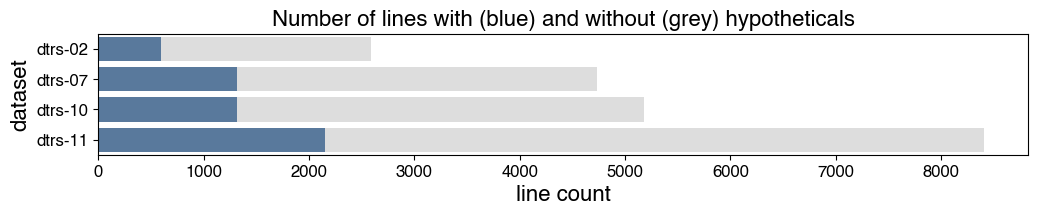

In [11]:
fig, ax = plt.subplots(figsize=(12, 1.6), dpi=100)
bars = sns.barplot(x = 'line count', y = 'dataset', color = "#dddddd",
                   data = df_counts[df_counts.type == 'total'])
bars.set_title("Number of lines with (blue) and without (grey) hypotheticals", fontsize=16)
bars = sns.barplot(x = 'line count', y = 'dataset', color = "#4e79a7",
                   data = df_counts[df_counts.type == 'hypotheticals'])

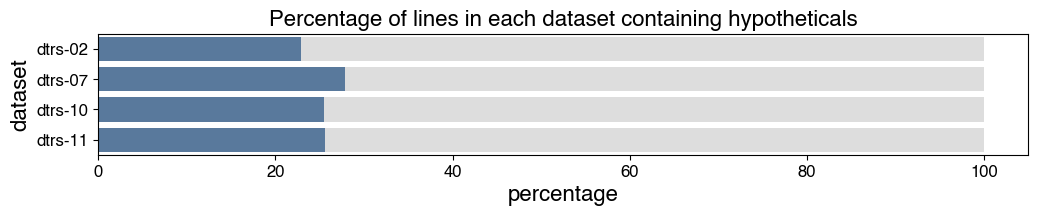

In [12]:
fig, ax = plt.subplots(figsize=(12, 1.6), dpi=100)
bars = sns.barplot(x = 'percentage', y = 'dataset', color = "#dddddd",
                   data = df_counts[df_counts.type == 'total'])
bars.set_title("Percentage of lines in each dataset containing hypotheticals", fontsize=16, fontweight='bold')
bars = sns.barplot(x = 'percentage', y = 'dataset', color = "#4e79a7",
                   data = df_counts[df_counts.type == 'hypotheticals'])

## Compute Proportions for each Session
Same as above, but this time at session-level

In [13]:
def session_counts(df, dataset):
    df_counts = pd.DataFrame(columns = ['dataset', 'session', 'type', 'line count', 'percentage'])
#     dataset_list = list(set(list(df['dataset'])))
    df_dataset = df[df.dataset == dataset]
    sessions_list = list(set(list(df_dataset['session'])))
    for session in sessions_list :
        df1 = df_dataset[df_dataset.session == session]
        category_column = df1['hypotheticals']
        non_category_count = sum(category_count == 0 for category_count in category_column)
        category_count = len(category_column) - non_category_count
        total = len(category_column)
        df_counts = df_counts.append({
            'dataset' : dataset,
            'session' : session,
            'type' : 'hypotheticals', 
            'line count' : category_count, 
            'percentage' : round(category_count/total * 100, 2)
        }, ignore_index=True)
        df_counts = df_counts.append({
            'dataset' : dataset, 
            'session' : session,
            'type' : 'non hypotheticals', 
            'line count' : non_category_count, 
            'percentage' : round(non_category_count/total * 100, 2)
        }, ignore_index=True)
        df_counts = df_counts.append({
            'dataset' : dataset, 
            'session' : session,
            'type' : 'total', 
            'line count' : total, 
            'percentage' : round(total/total * 100, 2)
        }, ignore_index=True)
    df_counts = df_counts.sort_values("session")
    return df_counts

In [14]:
df_02_counts = session_counts(df, 'dtrs-02')
df_02_counts

,dataset,session,type,line count,percentage
3,dtrs-02,think-aloud,hypotheticals,149,45.02
4,dtrs-02,think-aloud,non hypotheticals,182,54.98
5,dtrs-02,think-aloud,total,331,100.00
0,dtrs-02,three-person-discussion,hypotheticals,442,19.60
1,dtrs-02,three-person-discussion,non hypotheticals,1813,80.40
2,dtrs-02,three-person-discussion,total,2255,100.00


## Plot Counts at Session Level

In [15]:
def plot_sessions(df, dataset_name, percentage=True):
    df_dataset = session_counts(df, dataset_name)
    bar_width = 0.4
    num_bars = len(set(list(df_dataset['session'])))
    plot_height = bar_width * num_bars
    fig, ax = plt.subplots(figsize=(12, plot_height), dpi=300)
    if percentage :
        bars = sns.barplot(x = 'percentage', y = 'session', color = "#dddddd",
                           data = df_dataset[df_dataset.type == 'total'])
        bars = sns.barplot(x = 'percentage', y = 'session', color = "#4e79a7",
                           data = df_dataset[df_dataset.type == 'hypotheticals'])
        bars.set_title("Percentage of lines in each dataset containing hypotheticals", fontsize=16)
    else :
        bars = sns.barplot(x = 'line count', y = 'session', color = "#dddddd",
                           data = df_dataset[df_dataset.type == 'total'])
        bars = sns.barplot(x = 'line count', y = 'session', color = "#4e79a7",
                           data = df_dataset[df_dataset.type == 'hypotheticals'])
        bars.set_title("Number of lines in each dataset containing hypotheticals", fontsize=16)

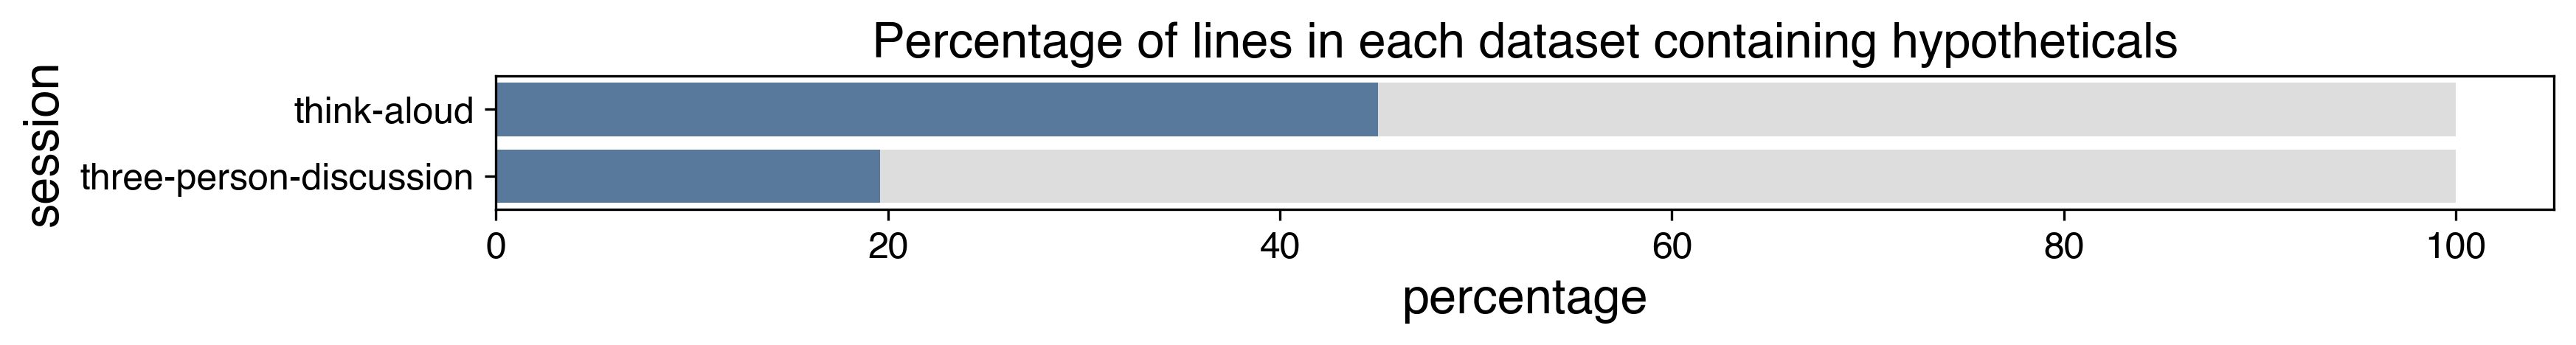

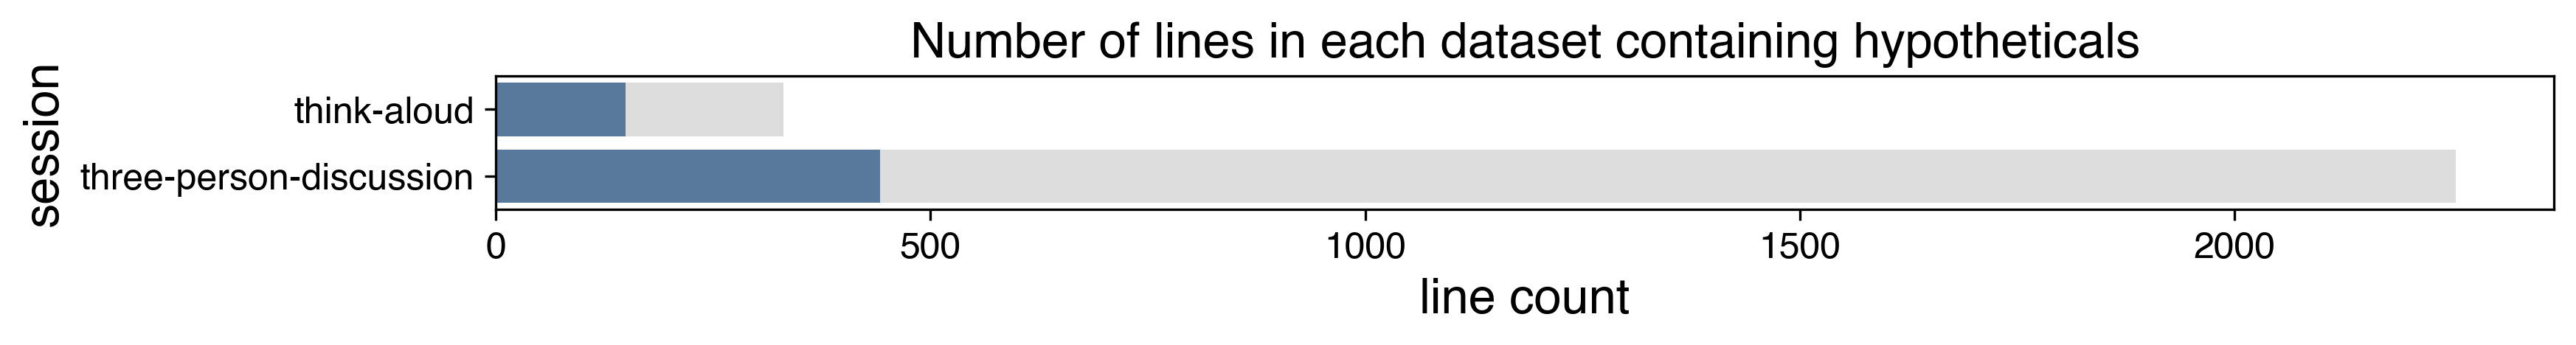

In [16]:
plot_sessions(df, 'dtrs-02')
plot_sessions(df, 'dtrs-02', percentage=False)

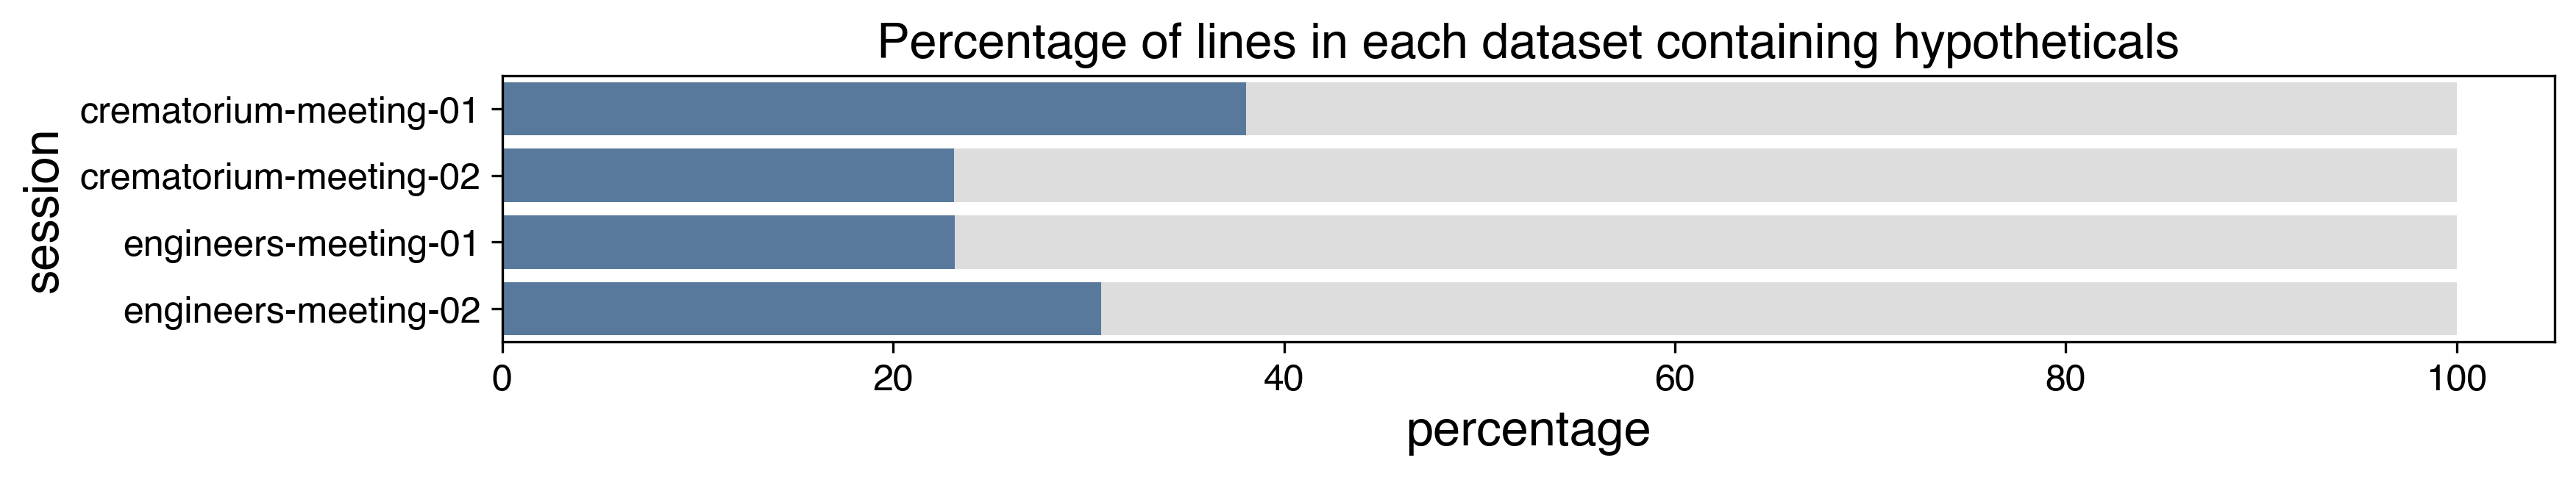

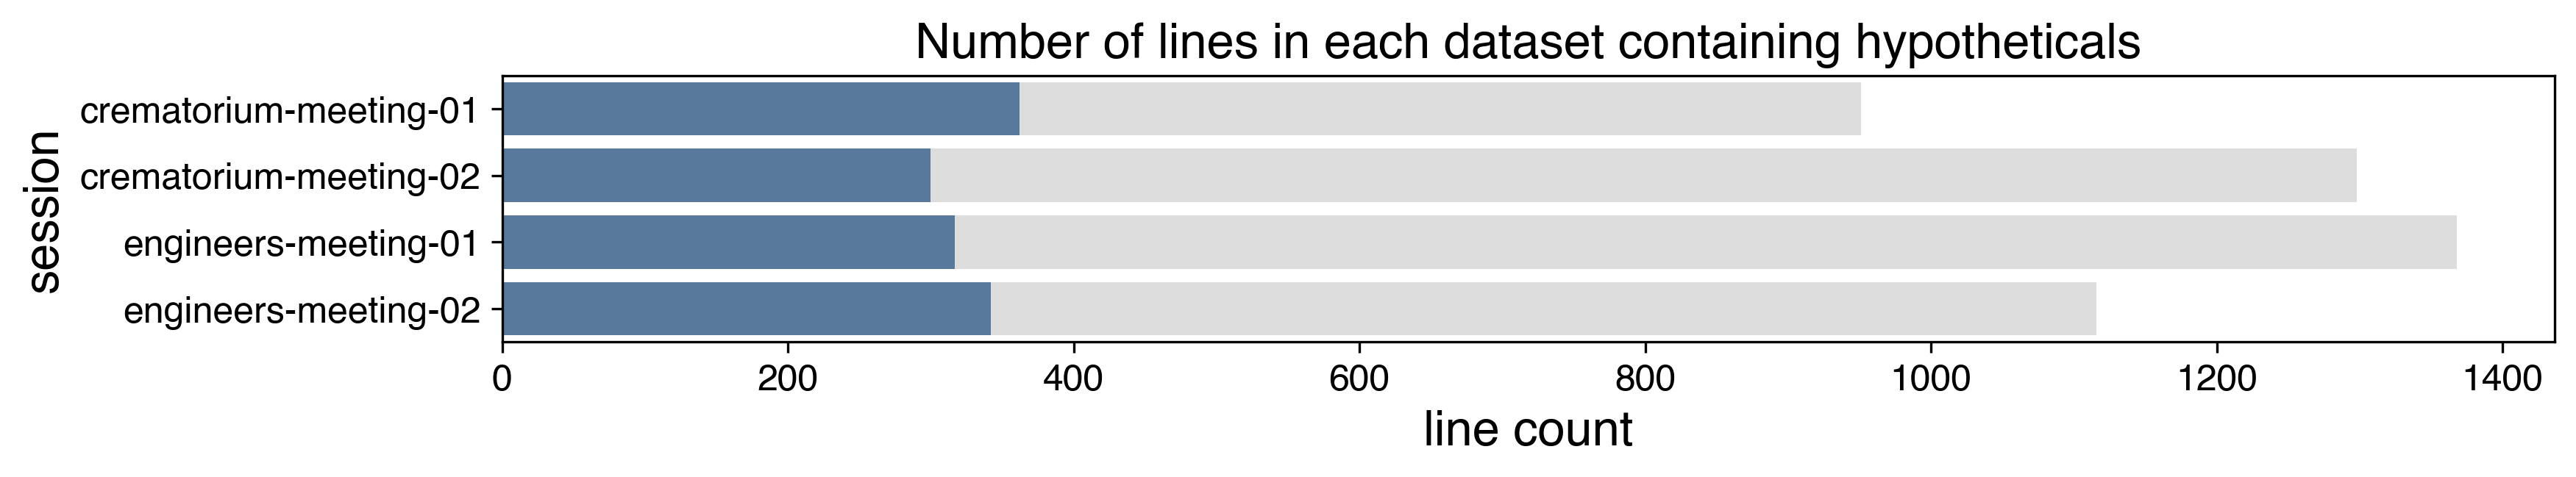

In [17]:
plot_sessions(df, 'dtrs-07')
plot_sessions(df, 'dtrs-07', percentage=False)

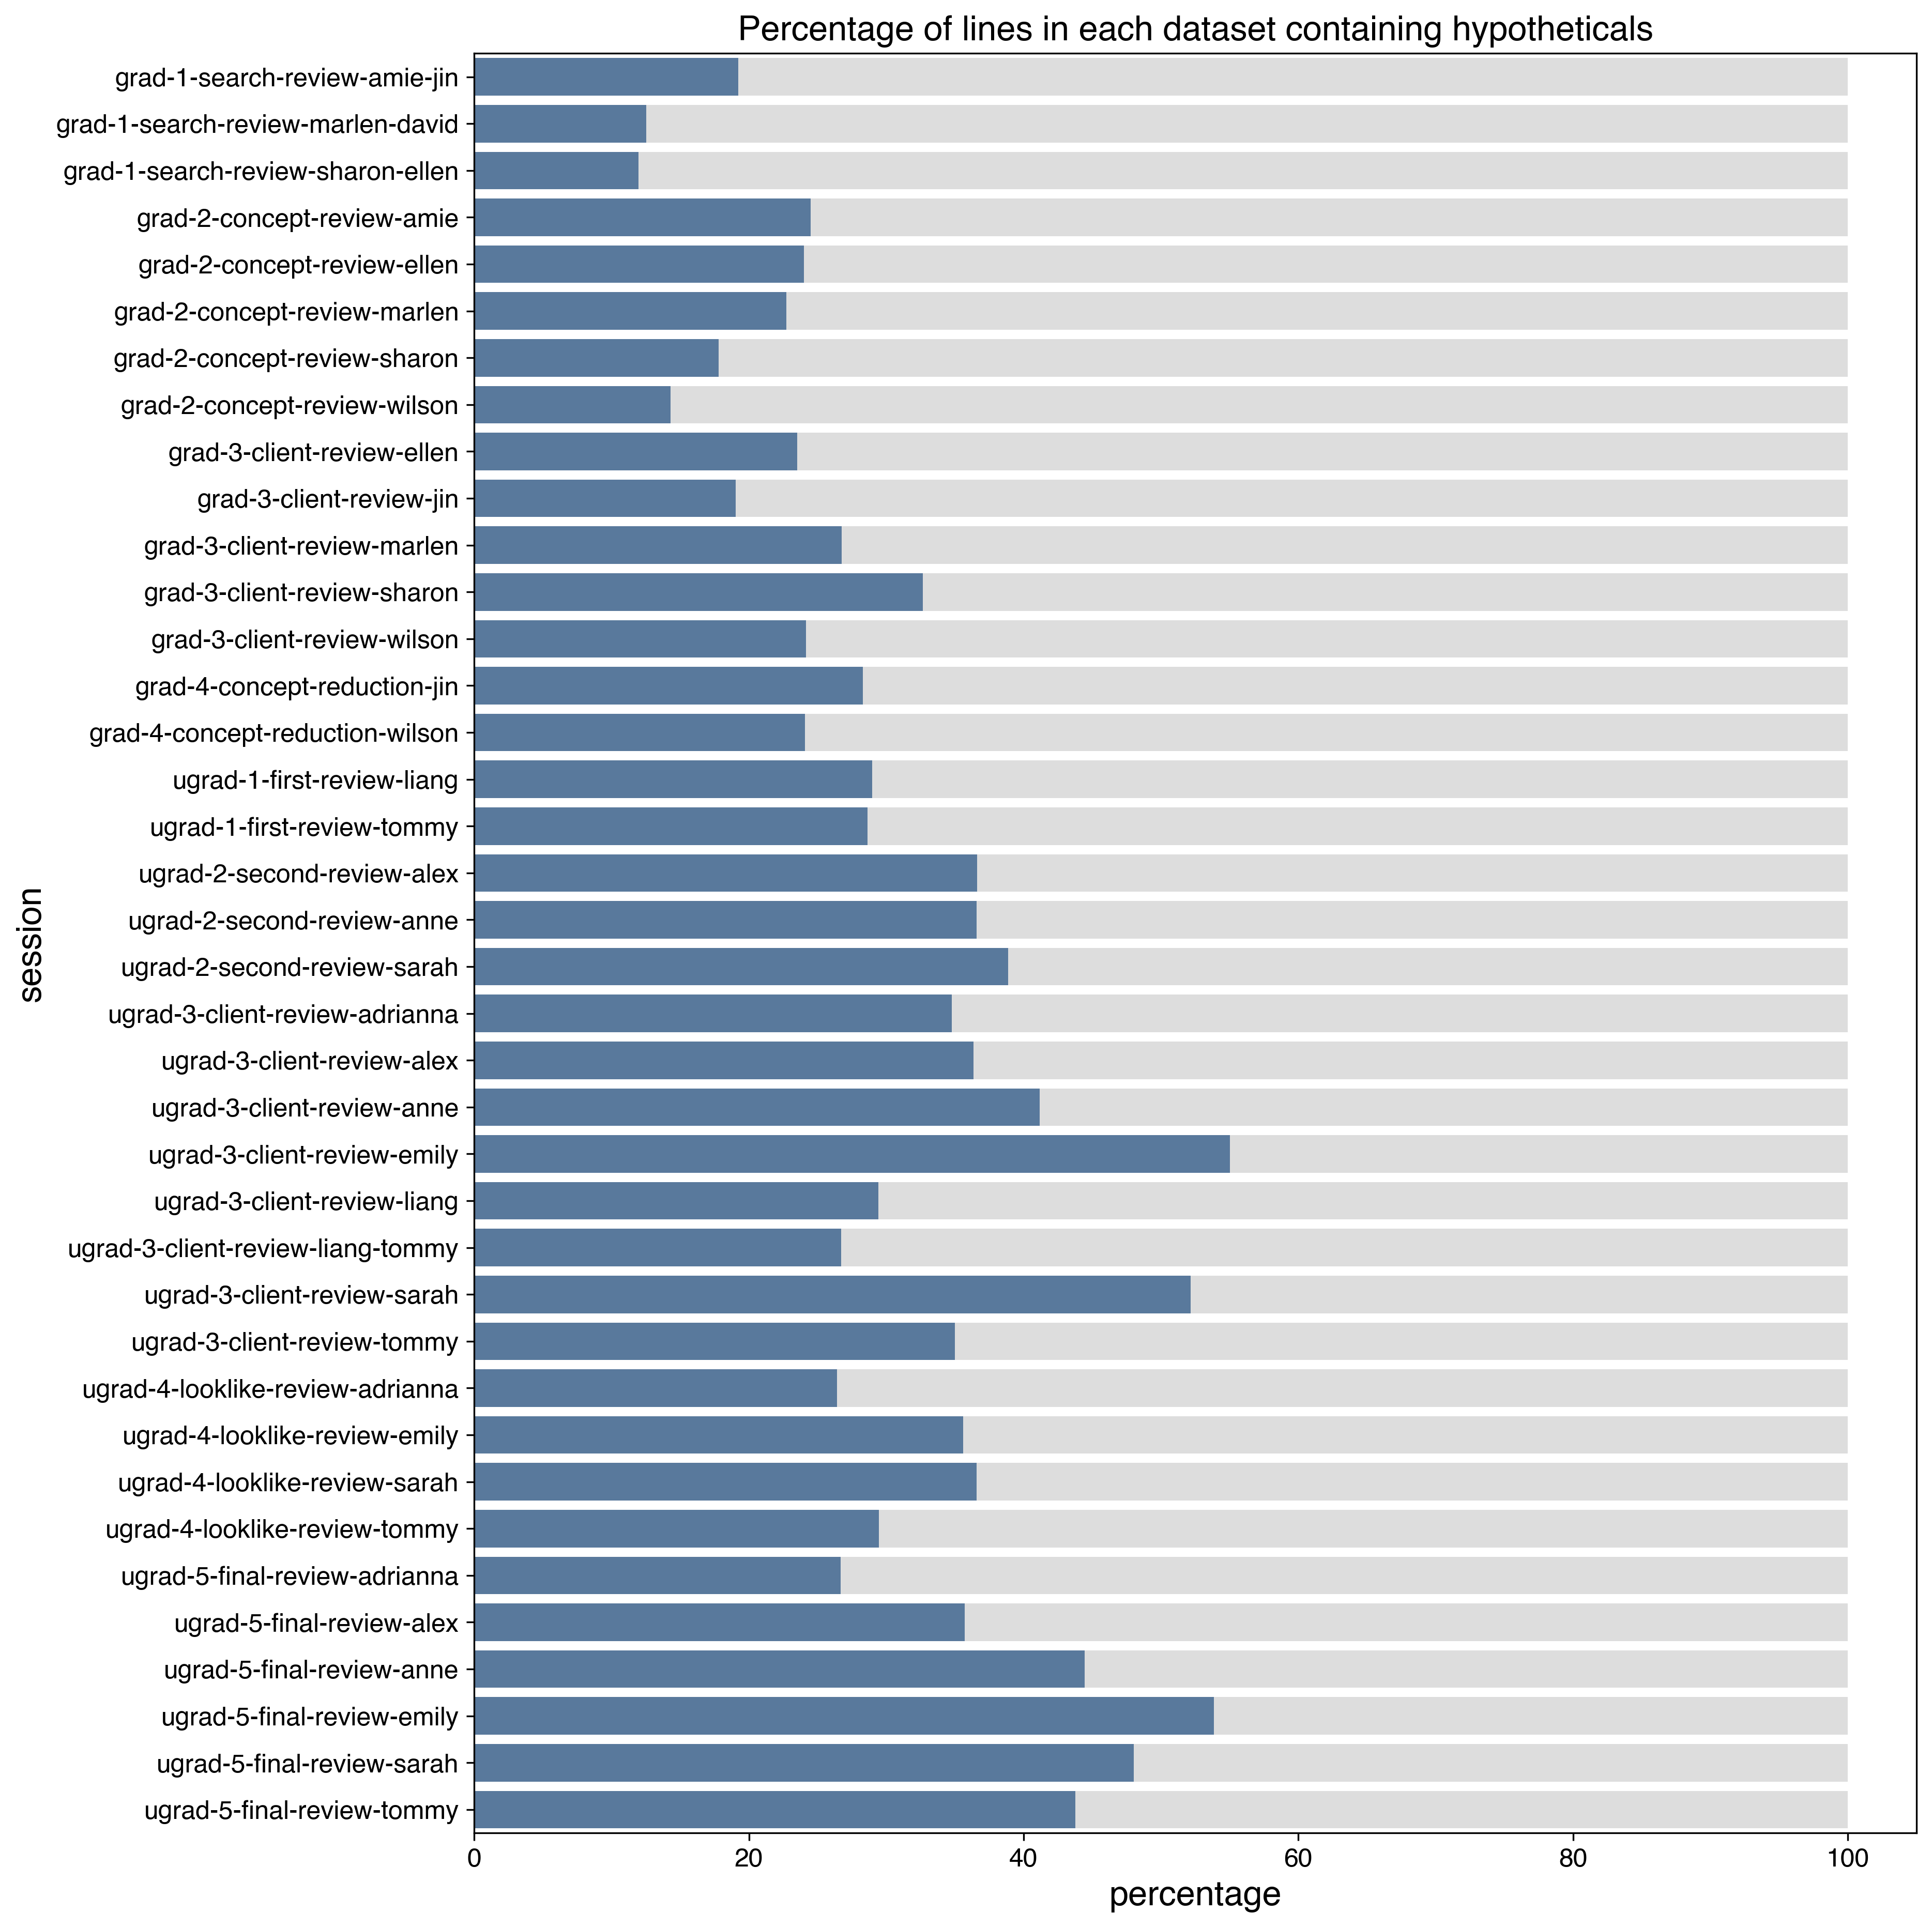

In [18]:
plot_sessions(df, 'dtrs-10')

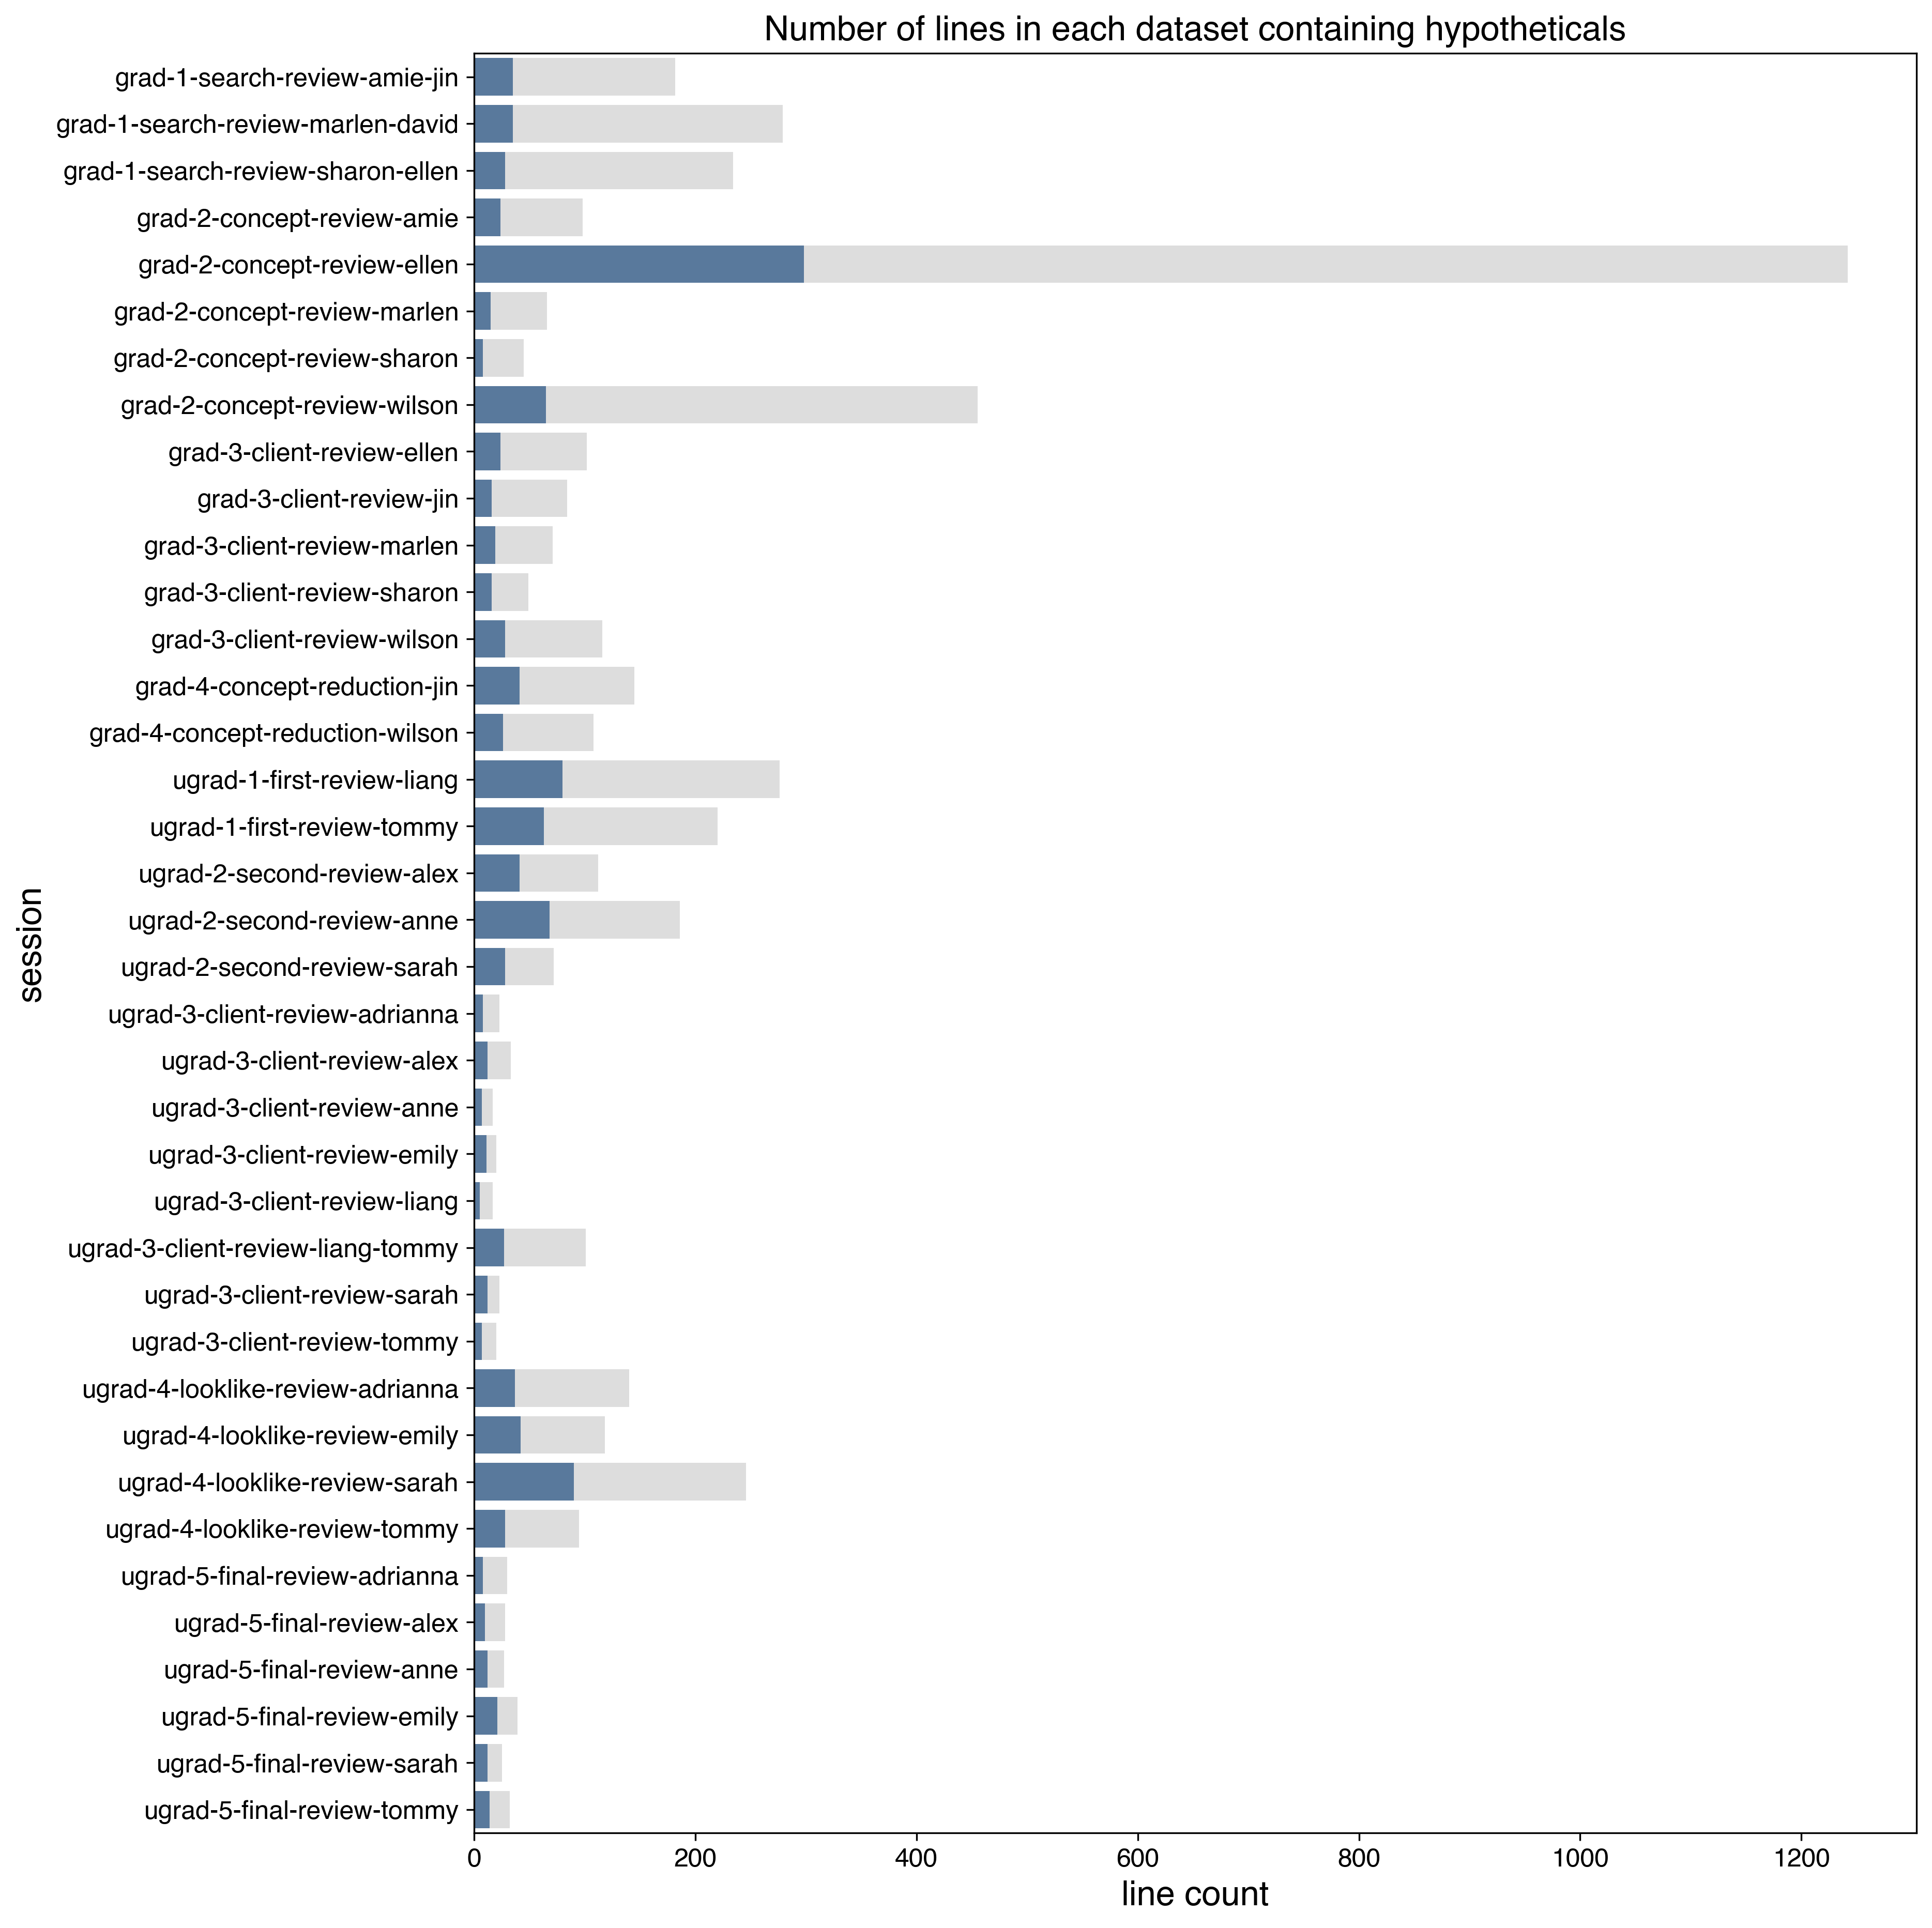

In [19]:
plot_sessions(df, 'dtrs-10', percentage=False)

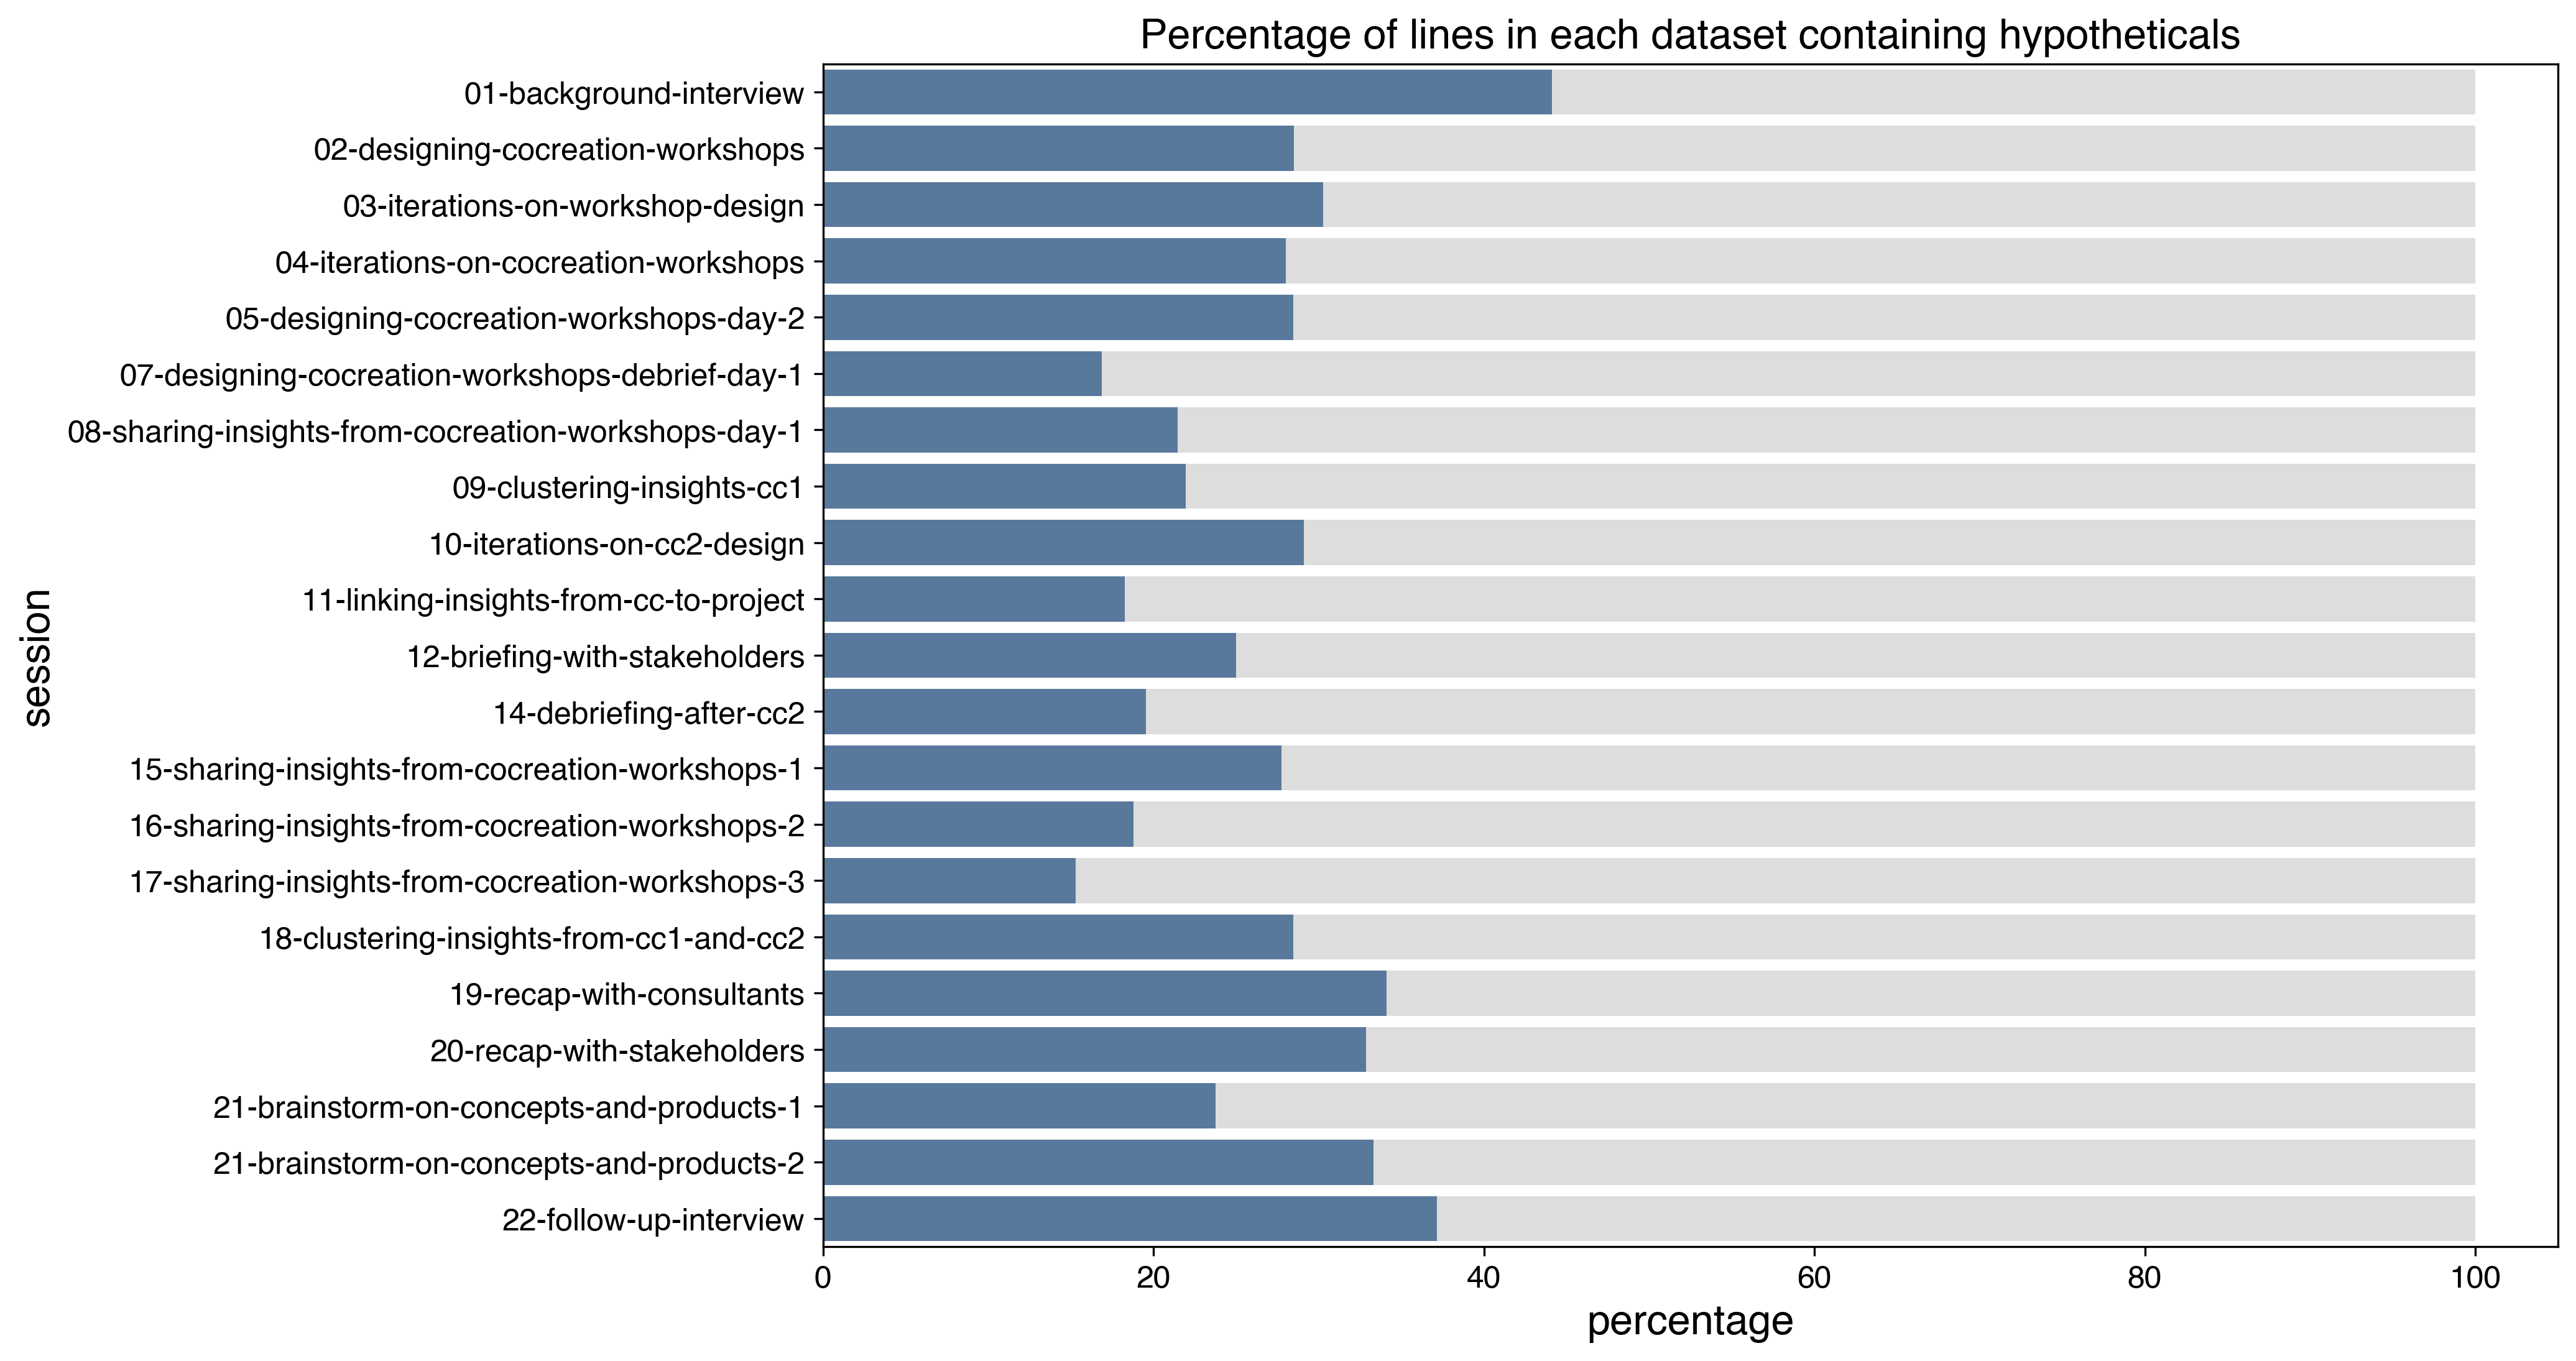

In [20]:
plot_sessions(df, 'dtrs-11')

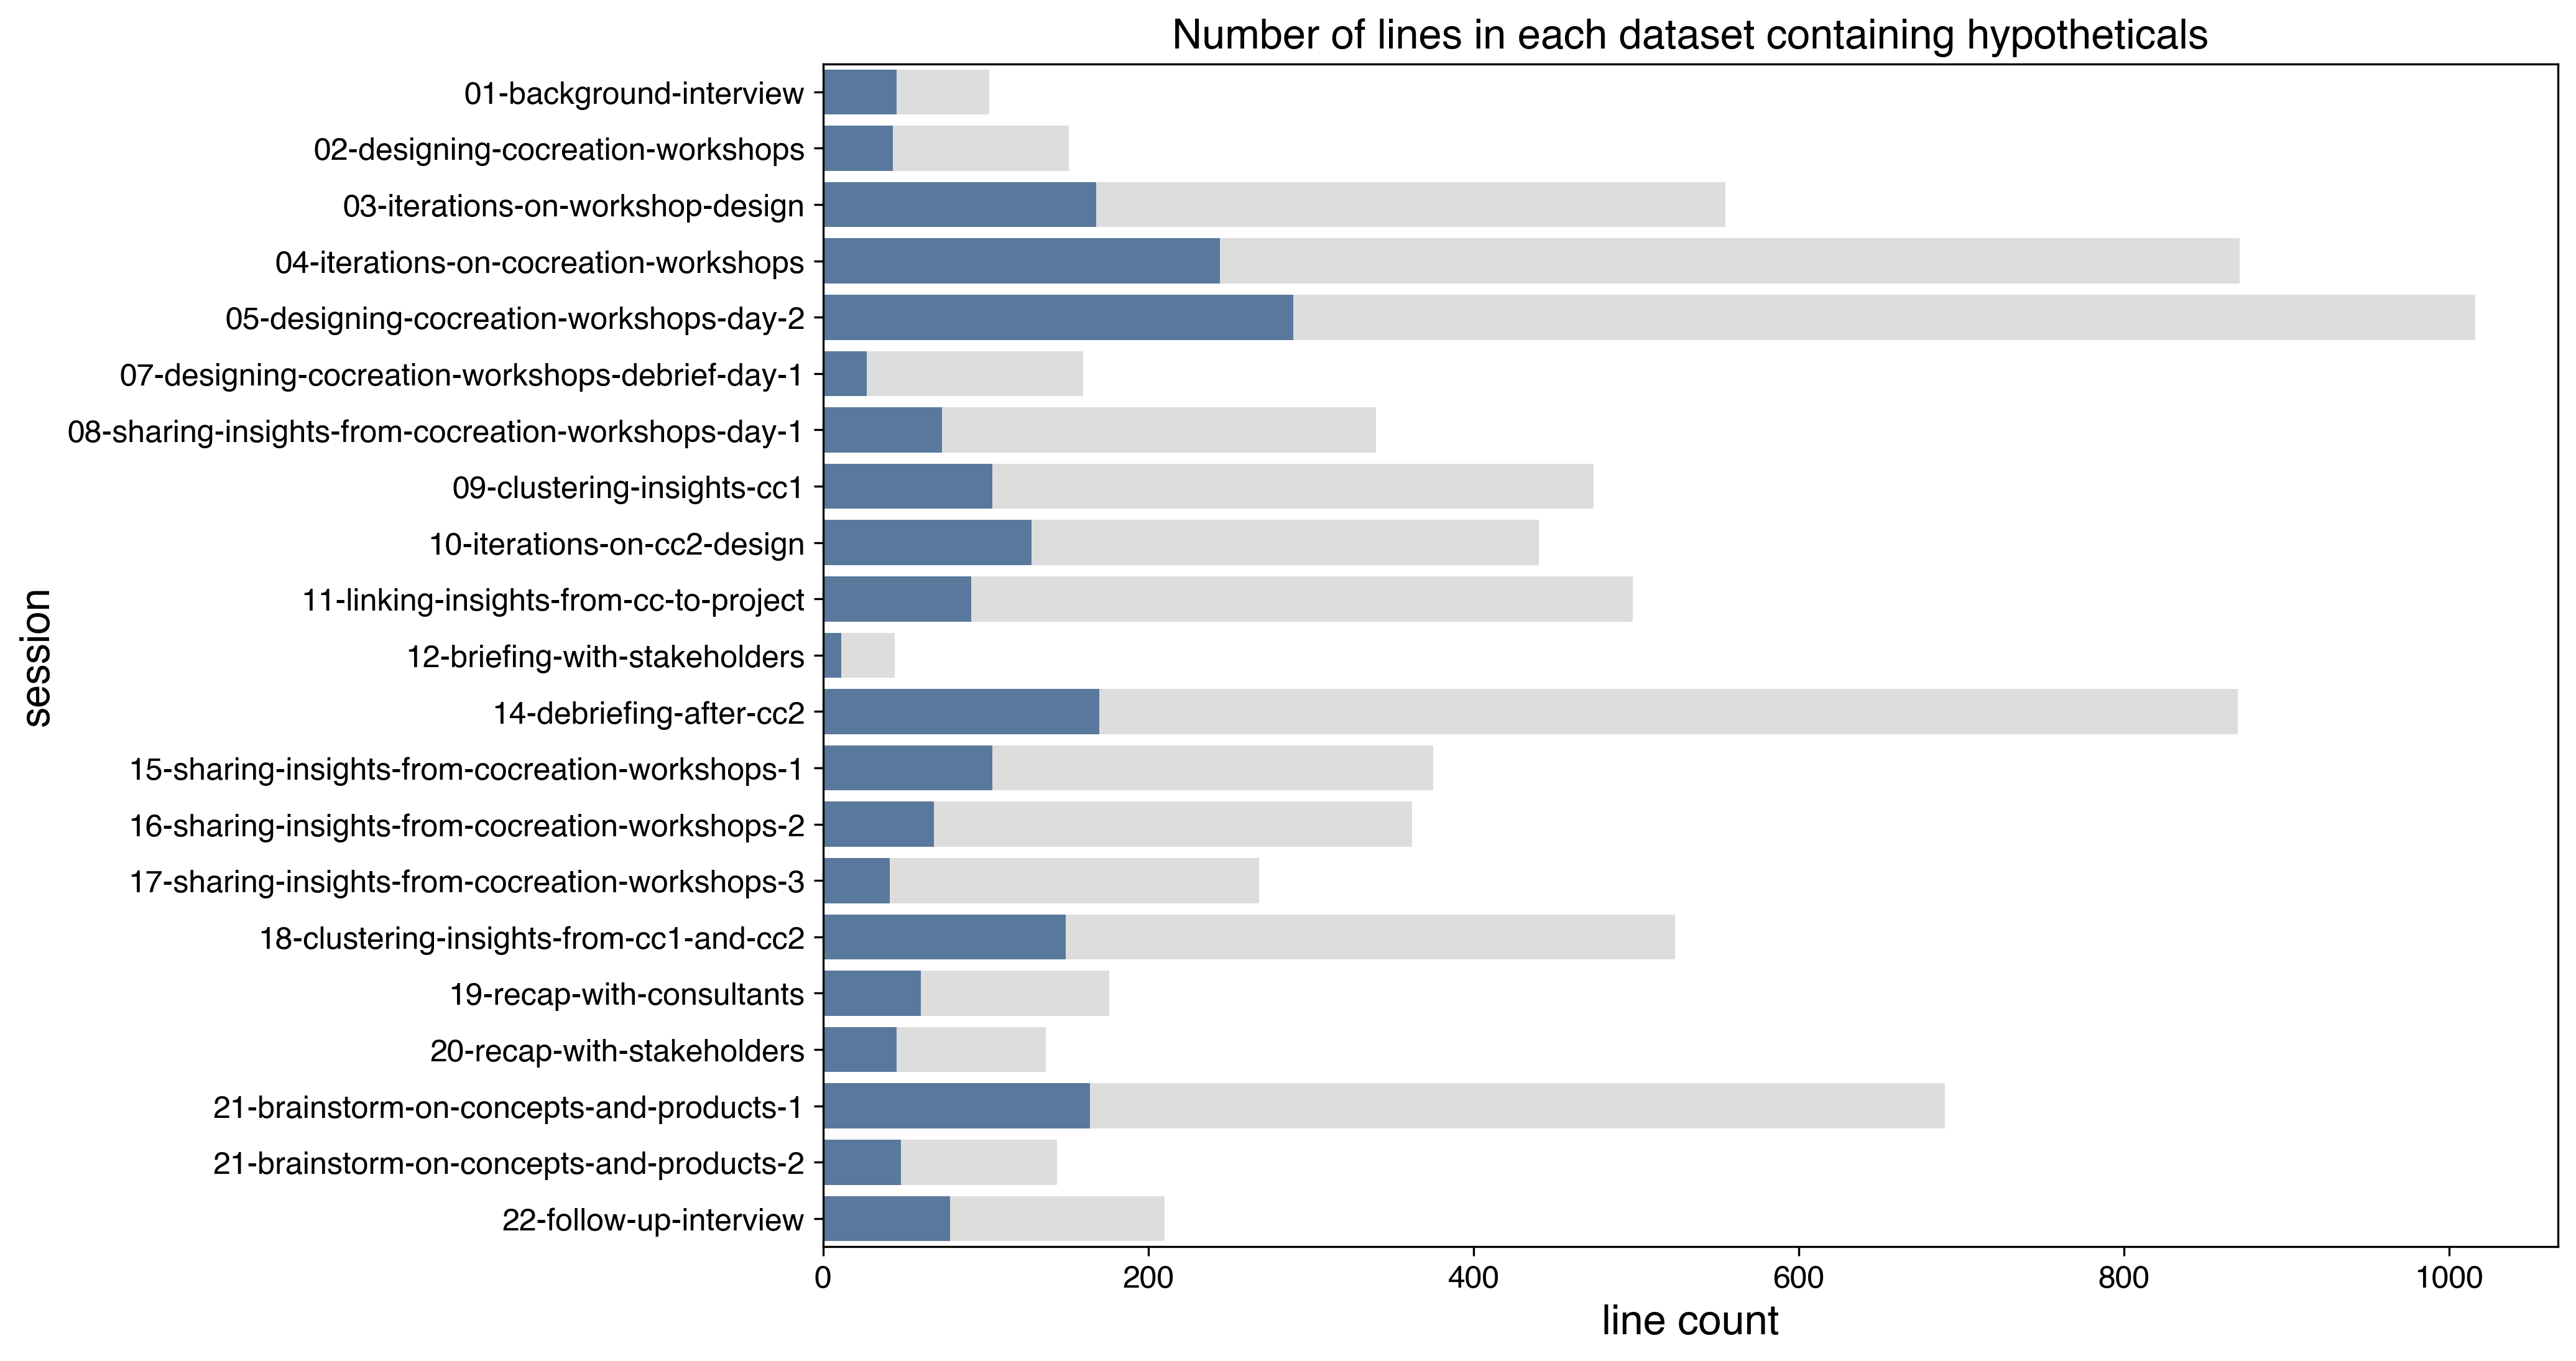

In [21]:
plot_sessions(df, 'dtrs-11', percentage=False)

## Plot subsets of sessions
This is more relevant to the DTRS-10 and DTRS-11 datasets. Identify session subsets (e.g. all graduate sessions in DTRS-10, all sessions with Jin in DTRS-10, all co-creation-related sessions in DTRS-11) and plot them.

In [22]:
def plot_session_subsets(df, subset_string, dataset_name, percentage=True):
    df_dataset = session_counts(df, dataset_name)
    df_subset = df_dataset[df_dataset.session.str.contains(subset_string)]
    bar_width = 0.4
    num_bars = len(set(list(df_subset.session)))
    plot_height = num_bars * bar_width
    fig, ax = plt.subplots(figsize=(12, plot_height), dpi=300)
    if percentage :
        bars = sns.barplot(x = 'percentage', y = 'session', color = "#dddddd",
                           data = df_subset[df_subset.type == 'total'])
        bars = sns.barplot(x = 'percentage', y = 'session', color = "#4e79a7",
                           data = df_subset[df_subset.type == 'hypotheticals'])
        bars.set_title("Percentage of lines in each session with '"+subset_string+"' containing hypotheticals",
                       fontsize=16)
    else :
        bars = sns.barplot(x = 'line count', y = 'session', color = "#dddddd",
                           data = df_subset[df_subset.type == 'total'])
        bars = sns.barplot(x = 'line count', y = 'session', color = "#4e79a7",
                           data = df_subset[df_subset.type == 'hypotheticals'])
        bars.set_title("Number of lines in each session with '"+subset_string+"' containing hypotheticals",
                       fontsize=16)
    

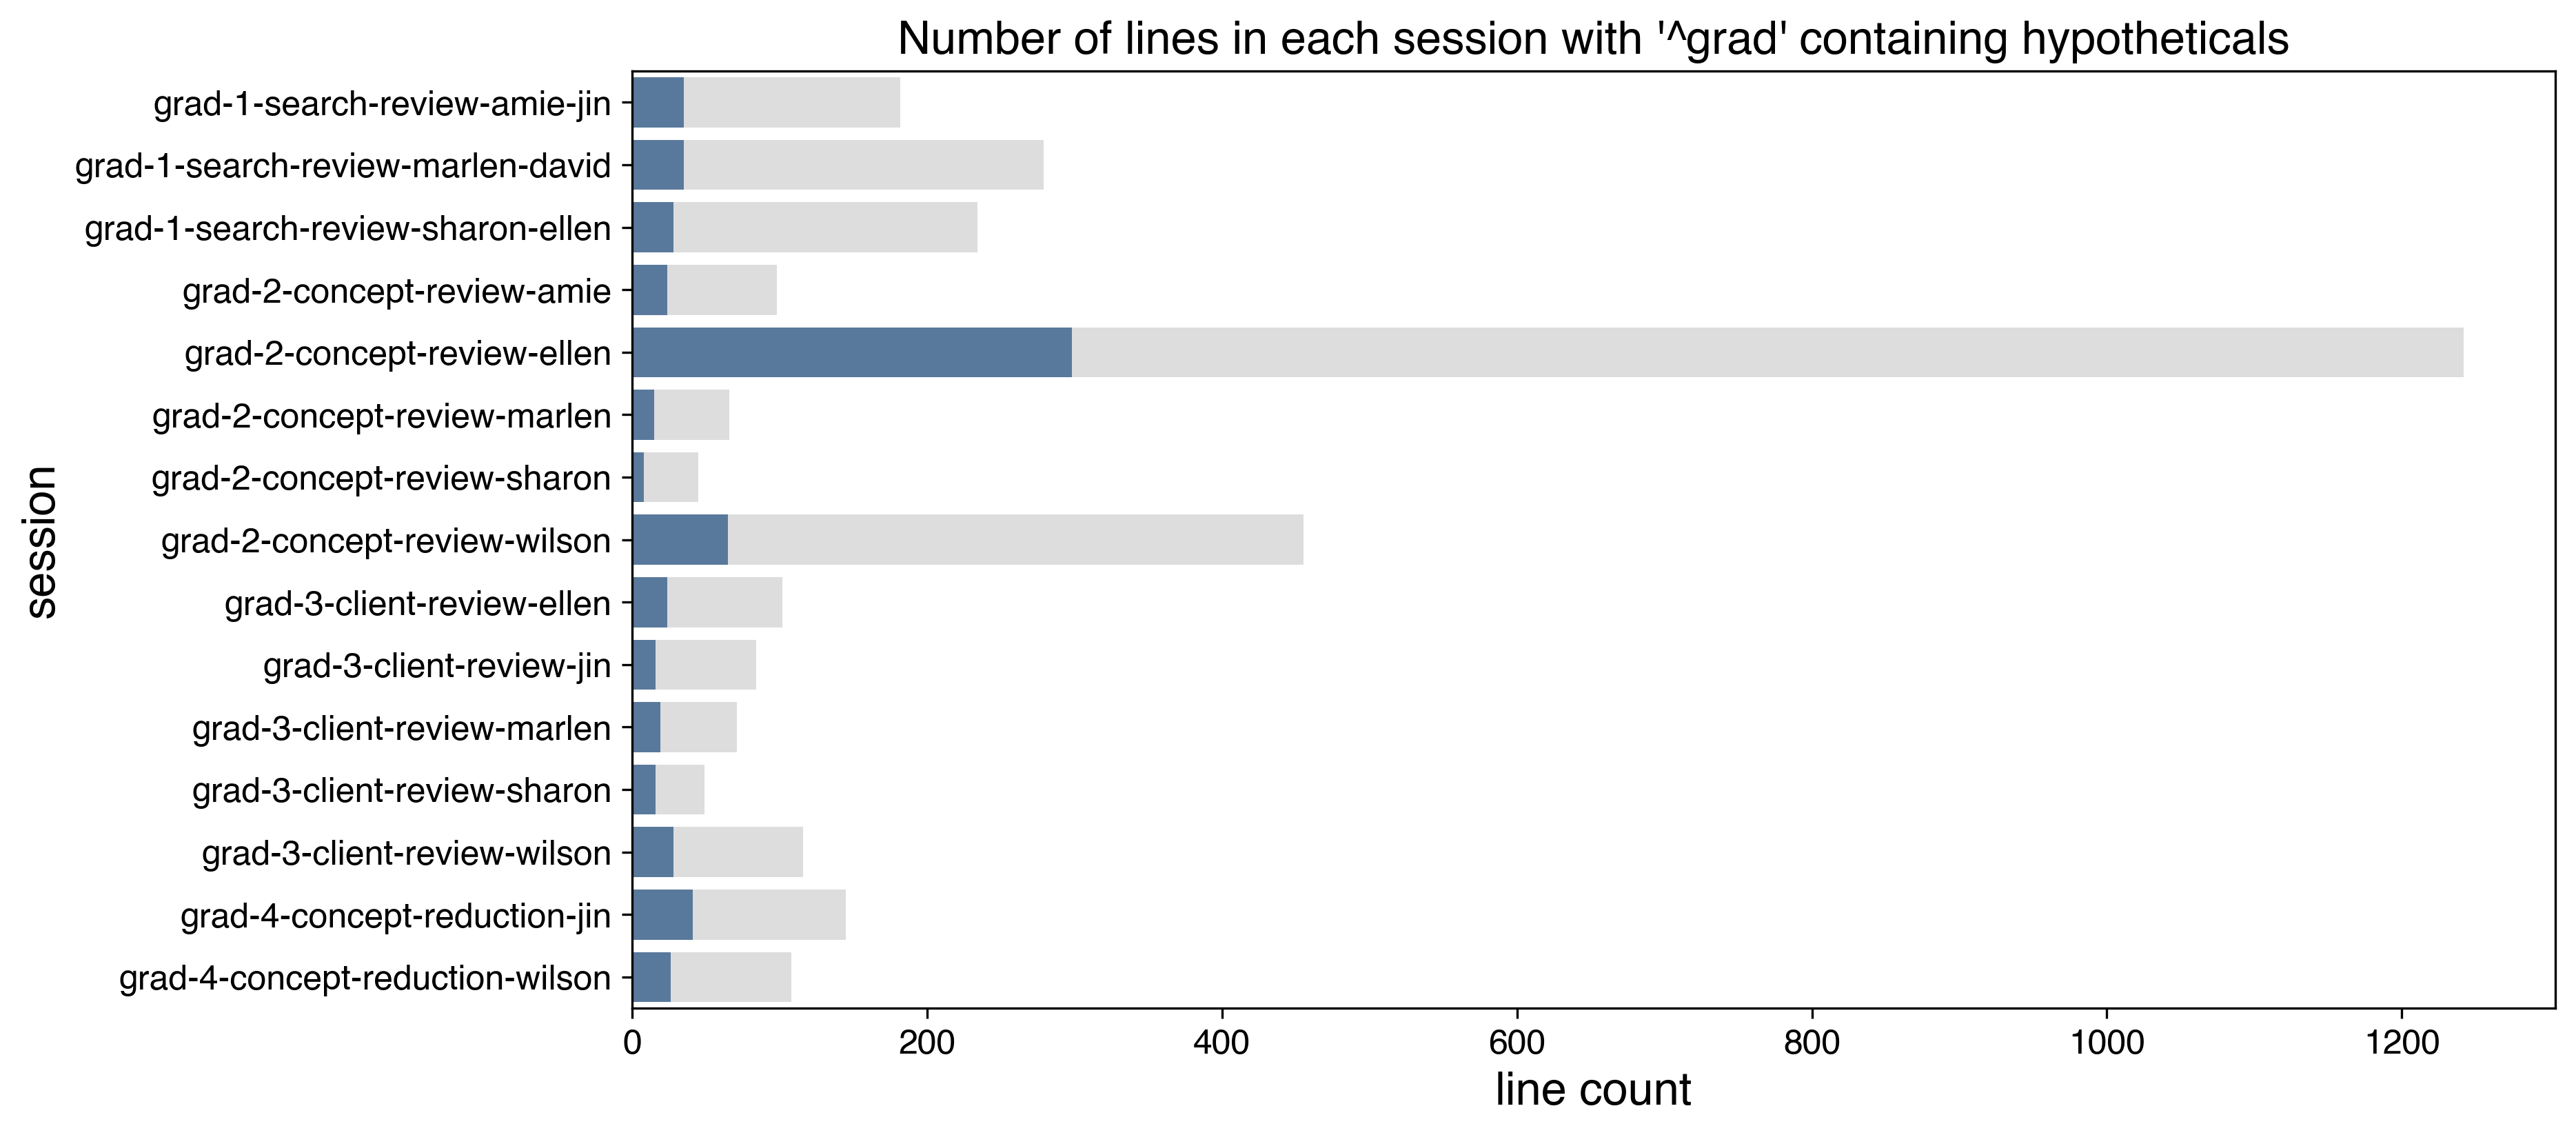

In [23]:
plot_session_subsets(df, '^grad', 'dtrs-10', percentage=False)

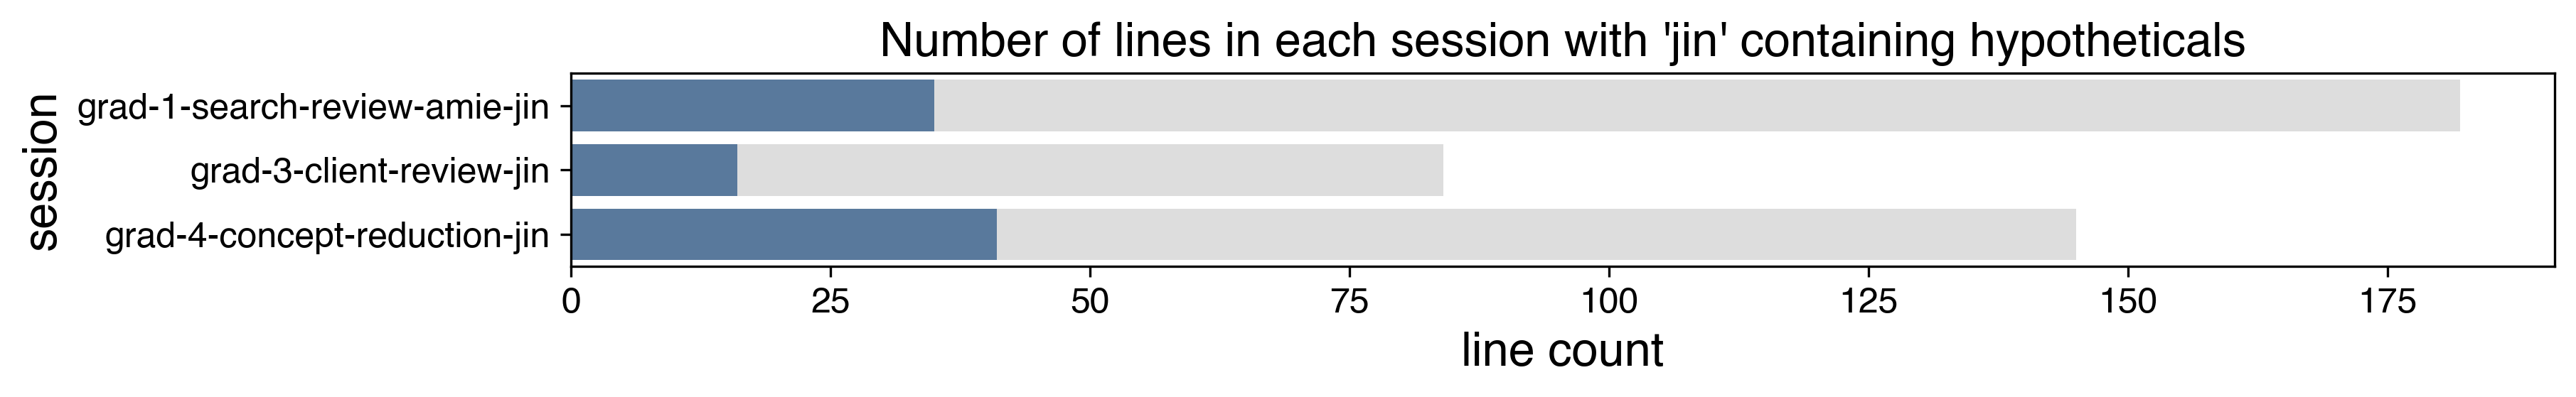

In [24]:
plot_session_subsets(df, 'jin', 'dtrs-10', percentage=False)

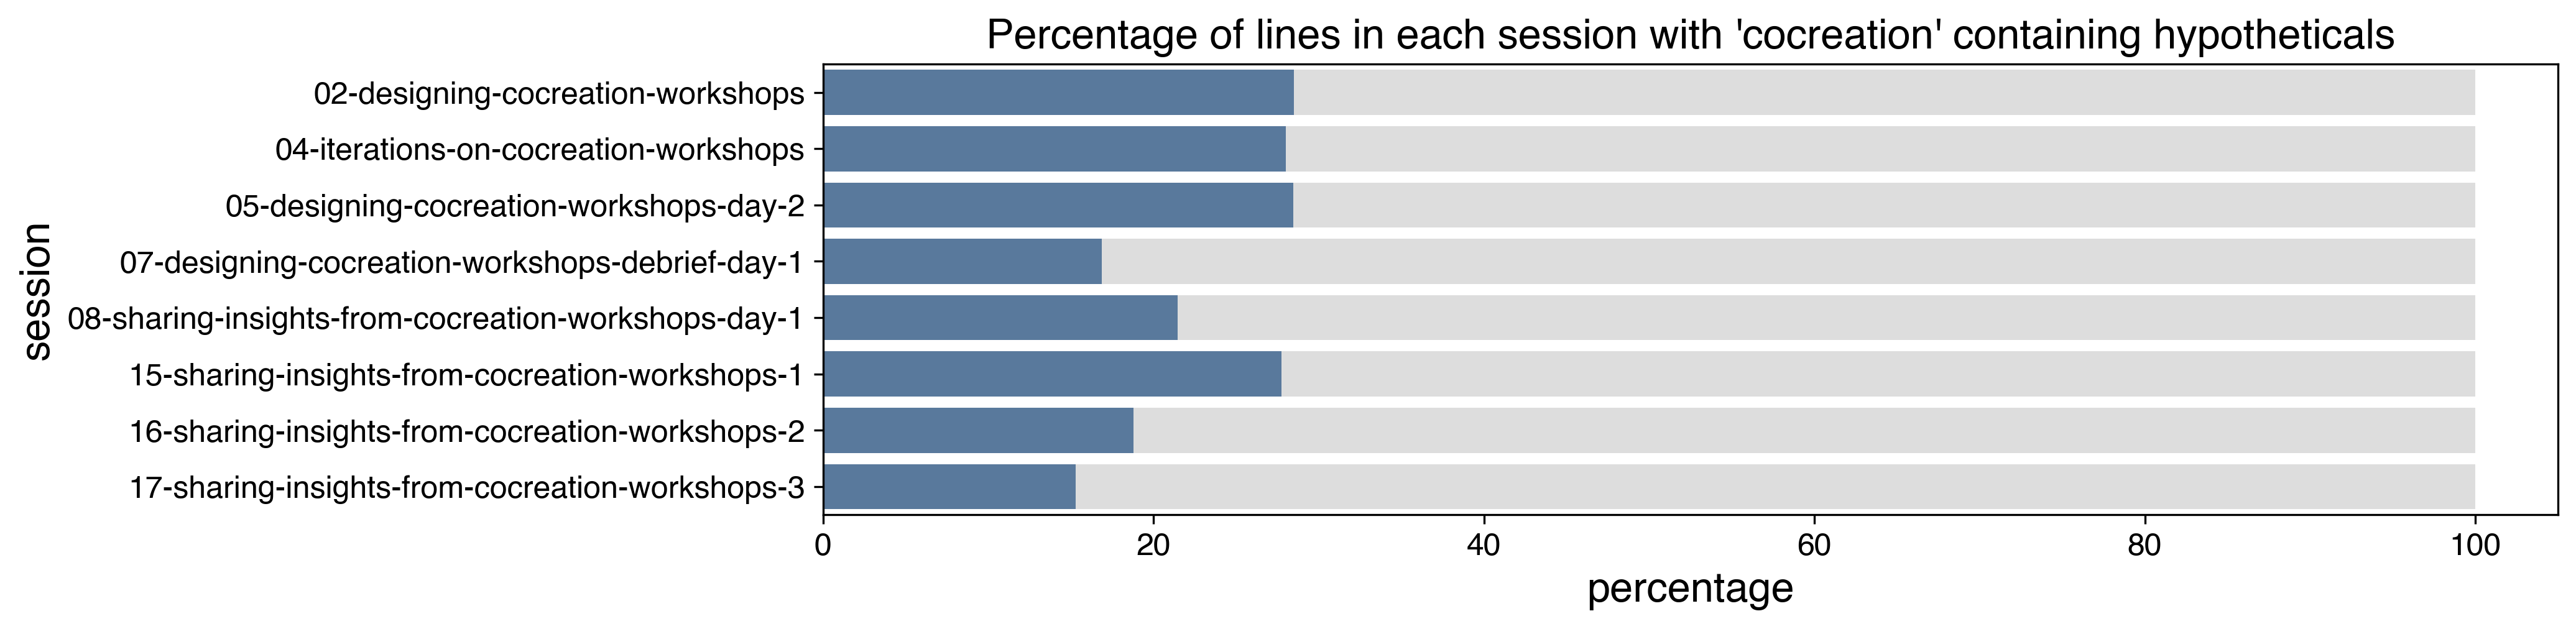

In [26]:
plot_session_subsets(df, 'cocreation', 'dtrs-11', percentage=True)

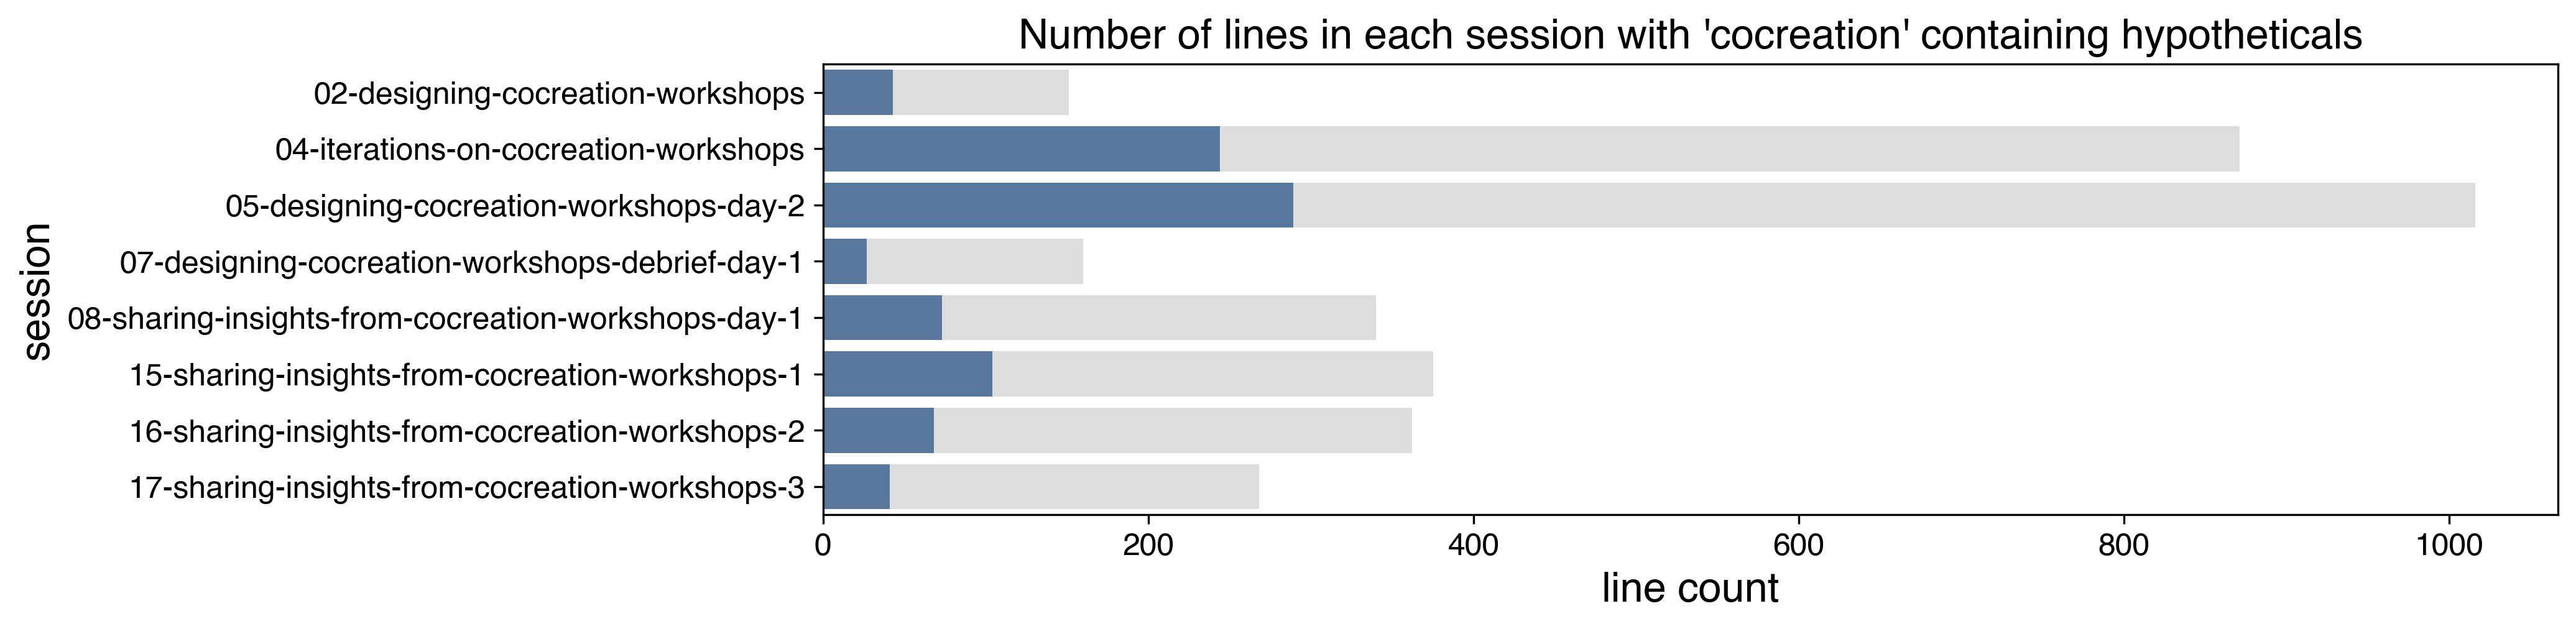

In [27]:
plot_session_subsets(df, 'cocreation', 'dtrs-11', percentage=False)

# Other Data to Plot
 - Same as above, but for "transportation"
 - (look up what happens in Vegas dataset)
 - Do above for ALL of the data (not separated by dataset)
 - Consider individual "hypothetical" indicator and plot them separately.
 - Add KWIC to the above
 - Add "memory" keywords "recall", "remember", "used to"
 - Tense analysis in general (for past tense)
 - Sentiment analysis, then look specifically for "agreement", "judgment" terms
 - Word cloud for each dataset (remove selective stop words)
 - What constitutes "grammar of a design conversation"?
 

# For InferKit
Send Peter stripped-down datasets separately (**Done**), and with duplication (with same number of lines) 